<h1>Blood RNA expression outlier detection</h1>

<h2>By first finding optimal cluster for single sample and then calculating zscores and p values</h2>

TODO:

- introduce denoising autoencoder/other method for batch normalization with minimal loss of integrety
- implement pathway analysis


In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
plt.style.use("seaborn-paper")

In [274]:
# define patient

patient = "GTEX-14PHX-0006-SM-9MQJN"
sample_size= 50

In [275]:
def open_gct_file(filepath):
    return pd.read_csv(filepath, sep='\t', encoding='utf8', skiprows=2)

In [276]:
df = open_gct_file("DATA/gene_reads_v10_whole_blood.gct.gz")
# load annotations
sample_annotations_df = pd.read_csv("DATA/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt", sep='\t')

/var/folders/rj/lbtpvbdj0yxdj_ttcp98v_3w0000gn/T/ipykernel_812/1034792904.py:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_annotations_df = pd.read_csv("DATA/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt", sep='\t')


In [277]:
df.head()

,Name,Description,GTEX-1117F-0005-SM-HL9SH,GTEX-111CU-0005-SM-GJ3PH,GTEX-111FC-0006-SM-H65Z1,GTEX-111YS-0006-SM-5NQBE,GTEX-1122O-0005-SM-5O99J,GTEX-1128S-0005-SM-5P9HI,GTEX-113IC-0006-SM-5NQ9C,GTEX-113JC-0006-SM-5O997,...,GTEX-ZVZQ-0006-SM-51MR8,GTEX-ZXES-0005-SM-57WCB,GTEX-ZXG5-0005-SM-57WCN,GTEX-ZY6K-0006-SM-GRR18,GTEX-ZYFC-0006-SM-HL9SK,GTEX-ZYFD-0005-SM-HL9SL,GTEX-ZYT6-0006-SM-HL9SM,GTEX-ZYVF-0005-SM-HL9SN,GTEX-ZYW4-0006-SM-HAUXL,GTEX-ZZPU-0006-SM-HL9SO
0,ENSG00000223972.5,DDX11L1,0,0,0,1,1,1,5,1,...,0,1,0,4,2,1,1,1,0,1
1,ENSG00000227232.5,WASH7P,54,119,53,48,64,161,221,45,...,153,94,184,209,165,235,175,50,65,122
2,ENSG00000278267.1,MIR6859-1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,ENSG00000243485.5,MIR1302-2HG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ENSG00000237613.2,FAM138A,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [278]:
# first lets do some normalisation and initial PCA analysis

# create a uniform feature but save the mapping to gene symbol for later use
ensmbl_to_genesymbol = df[["Name","Description"]]

df.drop(columns=["Description"], inplace=True) # inplace to save RAM

df = df.set_index("Name").T # transpose for samples in row, features in columns


In [279]:
#lets create a vector with total counts per row, sum counts / 1e6

total_counts = np.array([df.iloc[x,:].sum()/1e6 for x in range(df.shape[0])])

In [280]:
# calculate CPM..
df = (df.T / total_counts).apply(np.ceil).T


In [282]:
# drop levels with no gene expression counts
df = df.loc[:, (df != 0).any(axis=0)]

In [283]:
# Clean the insufficient covered genes from the data mean expression > 15

df = df.loc[:, (df.median() > 4 )] 

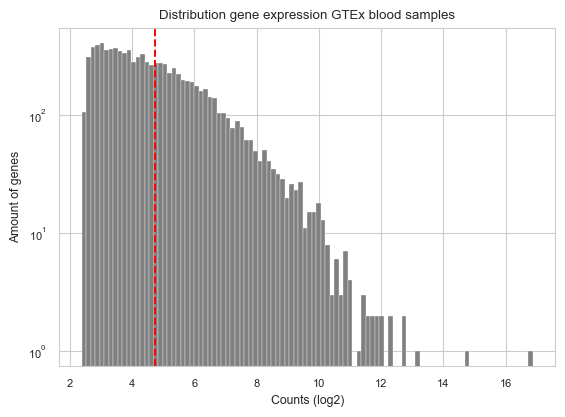

In [284]:
# lets check out how gene expression is distributed but first lets log2 transform the data 
def log_transform_data(x):
    return np.log2(x + 1)


df_log2 = df.apply(log_transform_data)

mean_expression_per_gene = df_log2.mean(axis=0)


plt.hist(x=mean_expression_per_gene, color='grey', bins=100, log=True)
plt.axvline(x=mean_expression_per_gene.mean(), color='red', ls='--')
plt.title("Distribution gene expression GTEx blood samples")
plt.xlabel("Counts (log2)")
plt.ylabel("Amount of genes")

plt.show()

In [285]:
pca = PCA()

pca.fit(df_log2)

PCA()

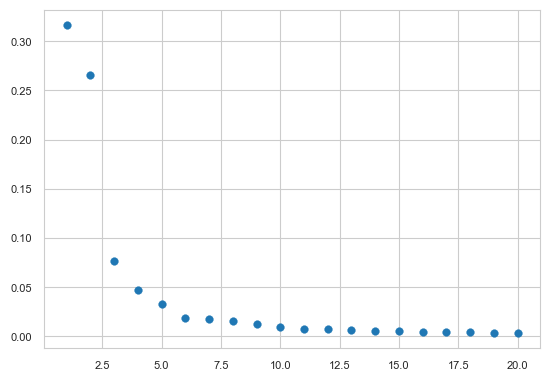

In [286]:

plt.scatter(x=np.arange(1,21), y=pca.explained_variance_ratio_[:20])

In [287]:
from sklearn.metrics import pairwise_distances

PC1_2 = pca.transform(df_log2)[:,:2]

index_pat = [c for c, s in enumerate(df.index) if s==patient]

print(index_pat)

# Compute pairwise Euclidean distances between samples
distances = pairwise_distances(PC1_2, metric='euclidean')

index_distance_dict = {c:d for c, d in enumerate(distances[index_pat].flatten())}

sorted_closest_pc_indexes = [k for  k, v in sorted(index_distance_dict.items(), key=lambda x:x[1])]

[218]


In [288]:


sample_ich = sample_annotations_df[["SAMPID","SMTSISCH"]][sample_annotations_df["SAMPID"].isin(df.index)]

sample_ich["color"] = ['grey' if x <= 0 else 'black' for x in sample_ich["SMTSISCH"]]

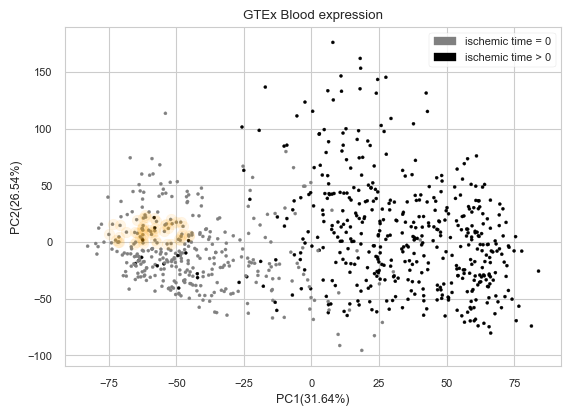

In [289]:
# plot with ischemic time. Keep only samples with 0 

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='black', label='ischemic time > 0')
blue_patch = mpatches.Patch(color='grey', label='ischemic time = 0')
plt.scatter(x=PC1_2[:,0], y=PC1_2[:,1], s=5, c=sample_ich["color"])
plt.scatter(x=PC1_2[sorted_closest_pc_indexes[:sample_size+1],0], y=PC1_2[sorted_closest_pc_indexes[:sample_size+1],1], s=60, c='orange', alpha=0.10)
plt.title("GTEx Blood expression")
plt.xlabel(f"PC1({pca.explained_variance_ratio_[0]*100:.02f}%)")
plt.ylabel(f"PC2({pca.explained_variance_ratio_[1]*100:.02f}%)")
plt.legend(handles=[blue_patch, red_patch])
plt.show()


In [290]:
df_log2 = df_log2.iloc[sorted_closest_pc_indexes[:sample_size+1]]
df = df.iloc[sorted_closest_pc_indexes[:sample_size+1]]

In [291]:
import seaborn as sns

corr = pd.DataFrame(np.corrcoef(df.T.values, rowvar=False), columns=df.T.columns)

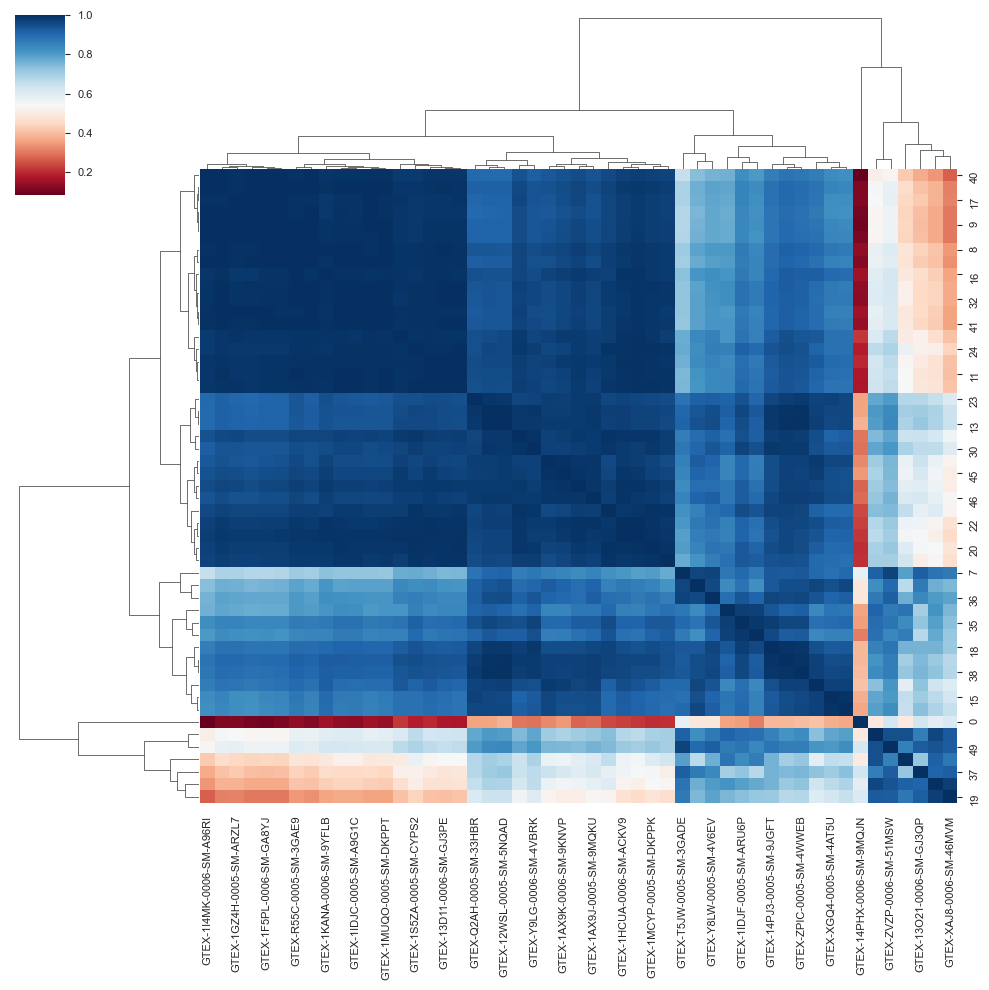

In [292]:
sns.set_style("whitegrid")
sns.clustermap(corr, cmap='RdBu', method="complete")

Some clustering shown, it would be best to normalize in some way.

In [293]:
# calculate zscores based on log2 counts
z_score_df = (df_log2 - df_log2.mean())/df_log2.std(ddof=0)

/var/folders/rj/lbtpvbdj0yxdj_ttcp98v_3w0000gn/T/ipykernel_812/469435259.py:47: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(data, kde=False, norm_hist=True, bins=100)


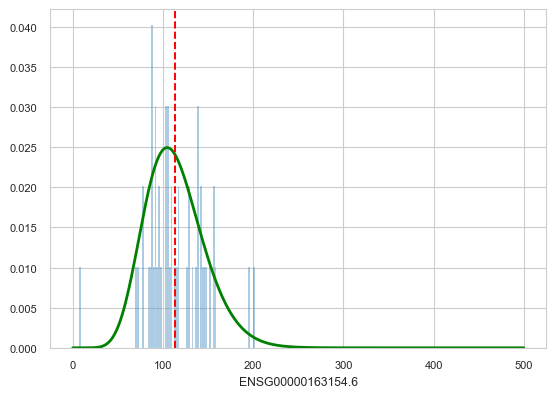

In [294]:
import statsmodels.api as sm
import scipy.stats as ss 
import seaborn as sns

# Use NB dist normally and fall back to Poisson dist if variance < mu

def get_nb_or_pois_val(s):
    mu = np.mean(s)
    sigma_sqr = np.var(s)
    if sigma_sqr >= mu:
        n = mu**2 / (sigma_sqr - mu)
        p = mu / sigma_sqr
        return "NB", mu, p, n
    else:
        # Poisson: If variance is not greater than mean, fall back to Poisson
        lambda_poisson = mu  # For Poisson, lambda = mu
        return "P", lambda_poisson

def two_tailed(pmf_values):
    return 2 * np.minimum(pmf_values, 1 - pmf_values)

def get_nb_or_pois_pvals(s):
    res = get_nb_or_pois_val(s)
    if res[0] == "NB":
        type_dist, mu, p, n = res
        pmf_values = ss.nbinom.pmf(s,n,p)
        return two_tailed(pmf_values)  # Two-tailed p-values
    else:
        type_dist, lambda_poisson = res
        pmf_values = ss.poisson.pmf(s,lambda_poisson)
        return two_tailed(pmf_values)  # Two-tailed p-values


data = df.iloc[:,:]["ENSG00000163154.6"]
x_plot = np.linspace(0,500,501)
res = get_nb_or_pois_val(data)

if res[0] == "NB":
    type_dist, mu, p, n = res
    pmf_values = ss.nbinom.pmf(x_plot,n,p)
    y_vals = two_tailed(pmf_values)  # Two-tailed p-values
else:
    type_dist, lambda_poisson = res
    pmf_values = ss.poisson.pmf(x_plot,lambda_poisson)
    y_vals = two_tailed(pmf_values)  # Two-tailed p-values

ax = sns.distplot(data, kde=False, norm_hist=True, bins=100)
ax.plot(x_plot, y_vals, 'g-', lw=2)
ax.axvline(x=mu, color='red', ls='--')
plt.show()


In [295]:
# Fit data to NB and get probabilities

p_value_df = df.apply(func=lambda x: get_nb_or_pois_pvals((x)))

In [296]:
from statsmodels.stats.multitest import multipletests


# Flatten the p-values into a single array
pvals = p_value_df.values.flatten()

# Apply FDR correction using B-Y procedure
# The result from multipletests is a tuple; we need the corrected p-values (last element of the tuple)
reject, pvals_corrected, _, _ = multipletests(pvals, method='fdr_by')

# Reshape the corrected p-values back into the original shape of the DataFrame
p_adj_df = pd.DataFrame(pvals_corrected.reshape(df.shape), columns=df.columns, index=df.index)

In [297]:


df_list = []
for patient_index in df.index:
    pat_df = pd.DataFrame({"patient":[patient_index for x in range(len(df.T.index))], "gene":df.T.index, "padj":p_adj_df.T[patient_index], "pValue":p_value_df.T[patient_index].values, "zScore":z_score_df.T[patient_index].values, "counts(CPM)":df.T[patient_index], "meanCounts(CPM)":df.mean().T}).reset_index()
    df_list.append(pat_df)

patients_df = pd.concat(df_list)
    


In [298]:
significant_df = patients_df[patients_df["padj"] < 0.05]

significant_df[(significant_df["patient"] == patient) & (significant_df["padj"] < 0.05)].sort_values("padj")

,Name,patient,gene,padj,pValue,zScore,counts(CPM),meanCounts(CPM)
2001,ENSG00000121858.11,GTEX-14PHX-0006-SM-9MQJN,ENSG00000121858.11,0.005038,1.562330e-09,-5.525751,37.0,235.568627
580,ENSG00000163154.6,GTEX-14PHX-0006-SM-9MQJN,ENSG00000163154.6,0.011163,5.192859e-09,-5.904655,7.0,113.725490


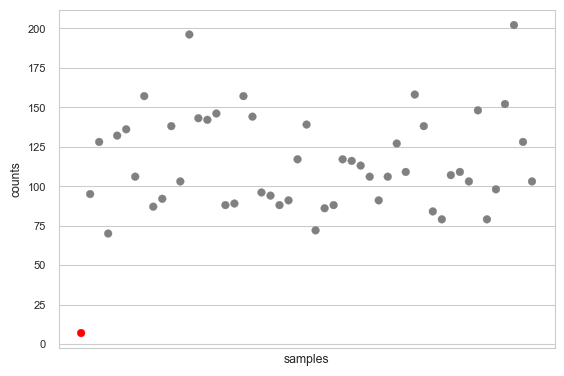

In [299]:
colors = ['red' if x == patient else 'grey' for x in df.index]
plt.scatter(df.index, df["ENSG00000163154.6"].values, c=colors)
plt.xlabel("samples")
plt.xticks([])
plt.ylabel("counts")
plt.show()

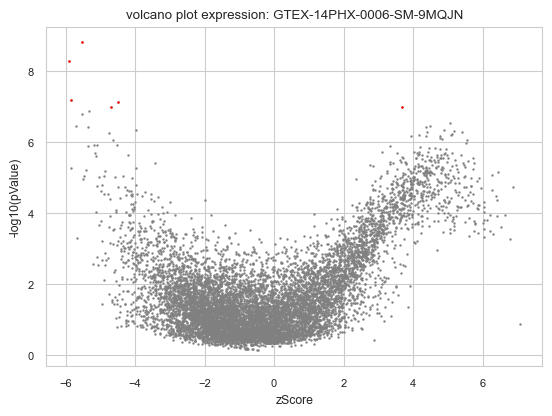

In [300]:
def negative_log10(x):
    return -np.log10(x)

plt.scatter(patients_df["zScore"][patients_df["patient"] == patient],negative_log10(patients_df["pValue"][patients_df["patient"] == patient]), s=2, color='grey')
plt.scatter(significant_df["zScore"][significant_df["patient"] == patient],negative_log10(significant_df["pValue"][significant_df["patient"] == patient]), s=2, color='red')

plt.xlabel("zScore")
plt.ylabel("-log10(pValue)")
plt.title(f'volcano plot expression: {patient}')

plt.show()